# Analyzing Trajectories

## Overview

### Questions

* How can I analyze trajectories?

### Objectives

* Describe how to access trajectory frames in **GSD**.
* Examine the trajectory with **freud** and **fresnel**.

## Boilerplate code

In [1]:
import gsd.hoomd
import fresnel
import math
import freud
import matplotlib
%matplotlib inline
matplotlib.style.use('ggplot')

The `render` function in the next cell will render a snapshot using **fresnel**.
`render_movie` will render aa iterable set of frames as an animated GIF.
These methods accept a *particles* argument that filters out which particles to display.

<div class="alert alert-info">
    This is not intended as a full tutorial on <b>fresnel</b> - see the <a href="https://fresnel.readthedocs.io/">fresnel user documentation</a> if you would like to learn more.
</div>

In [2]:
import fresnel, PIL, IPython, warnings, io, numpy

device = fresnel.Device()
tracer = fresnel.tracer.Path(device=device, w=370, h=370)

def render(snapshot, particles=None, is_solid=None):
    vertices=[(-0.5, 0, 0),
               (0.5, 0, 0),
               (0, -0.5, 0),
               (0, 0.5, 0),
               (0, 0, -0.5),
               (0, 0, 0.5)]
    poly_info = fresnel.util.convex_polyhedron_from_vertices(vertices)
    N = snapshot.particles.N
    L = snapshot.configuration.box[0]
    if particles is not None:
        N = len(particles)
    if is_solid is not None:
        N = int(numpy.sum(is_solid))
    
    scene = fresnel.Scene(device)
    geometry = fresnel.geometry.ConvexPolyhedron(scene,
                                                 poly_info,
                                                 N=N)
    geometry.material = fresnel.material.Material(color=(0.1, 0.7, 0.25),
                                                  roughness=0.8)
    if particles is None and is_solid is None:
        geometry.position[:] = snapshot.particles.position[:]
        geometry.orientation[:] = snapshot.particles.orientation[:]
    elif particles is not None:
        geometry.position[:] = snapshot.particles.position[particles, :]
        geometry.orientation[:] = snapshot.particles.orientation[particles, :]
    elif is_solid is not None:
        geometry.position[:] = snapshot.particles.position[numpy.ix_(is_solid, [0,1,2])]
        geometry.orientation[:] = snapshot.particles.orientation[numpy.ix_(is_solid, [0,1,2,3])]
        
        
    geometry.outline_width = 0.01
    box = fresnel.geometry.Box(scene, snapshot.configuration.box, box_radius=.02)
    
    scene.background_color = (1,1,1)
    scene.lights = fresnel.light.lightbox()
    scene.camera = fresnel.camera.orthographic(position=(0, 0, L+1),
                                               look_at=(0, 0, 0),
                                               up=(0, 1, 0),
                                               height=L+1)
    return tracer.sample(scene, samples=500)

def render_movie(frames, particles=None, is_solid=None):
    if is_solid is None:
        is_solid = [None]*len(frames)
    a = render(frames[0], particles, is_solid[0]);

    im0 = PIL.Image.fromarray(a[:,:, 0:3], mode='RGB').convert("P", palette=PIL.Image.ADAPTIVE);
    ims = [];
    for i,f in enumerate(frames[1:]):
        a = render(f, particles, is_solid[i]);
        im = PIL.Image.fromarray(a[:,:, 0:3], mode='RGB')
        im_p = im.quantize(palette=im0);
        ims.append(im_p)

    blank = numpy.ones(shape=(im.height, im.width, 3), dtype=numpy.uint8)*255
    im = PIL.Image.fromarray(blank, mode='RGB')
    im_p = im.quantize(palette=im0);
    ims.append(im_p)
            
    f = io.BytesIO()
    im0.save(f, 'gif', save_all=True, append_images=ims, duration=1000, loop=0)

    size = len(f.getbuffer())/1024;
    if (size > 3000):
        warnings.warn(f"Large GIF: {size} KiB")
    return IPython.display.display(IPython.display.Image(data=f.getvalue()))

## Equilibration challenges

In the previous section, we ran the hard octahedra system for many time steps to **equilibrate** it and saved the trajectory in `trajectory.gsd`.
Is the final **state** we obtained actually an **equilibrium state**?
Statistical mechanics tells us that as long as our system is *ergodic* it will *eventually* achieve equilibrium.
We need to analyze this trajectory to determine if we have achieved the ordered **equilibrium** structure.

## Tools

There are many tools that can read **GSD** files and analyze or visualize the simulations, and many more Python packages that can work with the numerical data.
We will use **freud** to determine which particles are in a solid-like environment and **fresnel** to render system configurations.
[Freud](https://freud.readthedocs.io/) is a Python package that provides a simple, flexible, powerful set of tools for analyzing trajectories obtained from molecular dynamics or Monte Carlo simulations.
[Fresnel](https://fresnel.readthedocs.io/) is a Python package that produces publication quality renders with soft lighting, depth of field and other effects.

## Read the trajectory

Let's use **GSD** to open the **trajectory** generated by the previous section of this tutorial.

In [3]:
traj = gsd.hoomd.open('trajectory.gsd')

We can index into the frames of the trajectory like a list.
Let's see how many frames we have to work with.

In [4]:
len(traj)

100

## Ergodicity

A system is *ergodic* when it can explore the network of all possible states by making small moves from one to another.
In HPMC simulations, low packing fraction simulations are ergodic while very high packing fraction ones are not.
At high packing fraction, there isn't enough free space for the particles to rearrange so they get stuck in local configurations.
Let's visualize the motion of just a few particles in our simulation and see if they appear stuck or if they are freely moving about the box.

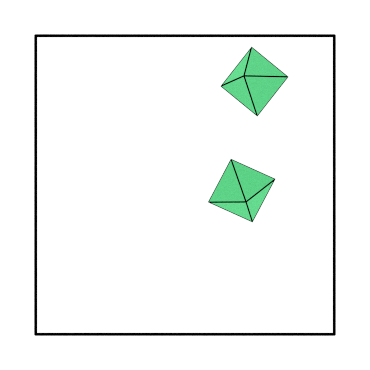

In [5]:
render_movie(traj[0:50:5], particles=[10, 40])

Good!
Over the first part of the simulation (while the system is still fluid), individual particles are able to move a significant distance and explore many different orientations.
This indicates that our system is *ergodic*.

## Simulation length

How do we know if we have run long enough to **equilibrate** the system?
The hard octahedra system forms the bcc structure [by nucleation and growth](https://doi.org/10.1038/ncomms14038).
Nucleation is a rare event, so we need to keep running the simulation until it occurs.
If we ran this simulation many times with different random seeds, each would take a different number of steps to nucleate.
We need to examine the simulation trajectory in detail to determine if we have run a particular simulation long enough.

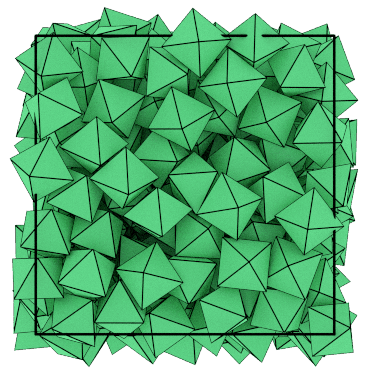

In [6]:
render_movie(traj[0:60:3])

Can you see the system ordering?
It happens very quickly.
Let's use **freud's SolidLiquid** analysis method to quantitatively identify which particles are in the solid structure.

Loop over all of the frames in the file and create a boolean array that indicates which particles are in a solid environment.

In [7]:
solid = freud.order.SolidLiquid(l=6, q_threshold=0.7, solid_threshold=6)
is_solid = []
for frame in traj:
    solid.compute(system=(frame.configuration.box, frame.particles.position),
                  neighbors=dict(mode='nearest', num_neighbors=8))
    is_solid.append(solid.num_connections > solid.solid_threshold)

Plot the total number of particles in a solid environment over time:

In [8]:
fig = matplotlib.figure.Figure(figsize=(10, 6.18))
ax = fig.add_subplot()
num_solid = [numpy.sum(a) for a in is_solid]
ax.plot(num_solid)
ax.set_xlabel('frame')
ax.set_ylabel('number of particles in a solid environment')
fig

This plot confirms what we saw visually and what we expect about systems that nucleate.
There is no solid at the beginning of the simulation.
Then a solid cluster forms and grows quickly to fill the box.
Let's visualize just the solid particles to see this more clearly.

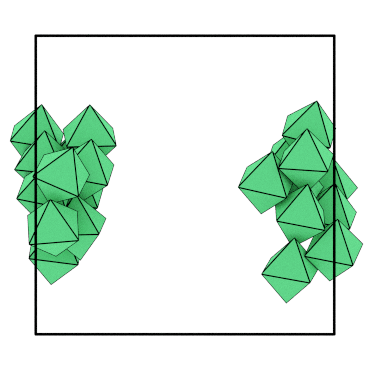

In [9]:
start_frame = int(numpy.argmax(numpy.array(num_solid) > 2))
end_frame = start_frame+8
render_movie(traj[start_frame:end_frame], is_solid=is_solid[start_frame:end_frame])

[Previous section](06-Equilibrating-the-System.ipynb). [Tutorial index](../README.md).